## 타이타닉 데이터셋 도전

- 승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표

- [캐글](https://www.kaggle.com)의 [타이타닉 챌린지](https://www.kaggle.com/c/titanic)에서 `train.csv`와 `test.csv`를 다운로드
- 두 파일을 각각 datasets 디렉토리에 titanic_train.csv titanic_test.csv로 저장

### 1. 데이터 적재

In [1]:
import pandas as pd
train_data = pd.read_csv("datasets/titanic_train.csv")
test_data = pd.read_csv("datasets/titanic_test.csv")

### 2. 데이터 탐색

#### train_data 살펴보기

In [2]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* **Survived**: 타깃. 0은 생존하지 못한 것이고 1은 생존을 의미
* **Pclass**: 승객 등급. 1, 2, 3등석.
* **Name**, **Sex**, **Age**: 이름 그대로의 의미
* **SibSp**: 함께 탑승한 형제, 배우자의 수
* **Parch**: 함께 탑승한 자녀, 부모의 수
* **Ticket**: 티켓 아이디
* **Fare**: 티켓 요금 (파운드)
* **Cabin**: 객실 번호
* **Embarked**: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)


#### 누락 데이터 살펴보기

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- **Age**, **Cabin**, **Embarked** 속성의 일부가 null
- 특히 **Cabin**은 77%가 null. 일단 **Cabin**은 무시하고 나머지를 활용
- **Age**는 177개(19%)가 null이므로 이를 어떻게 처리할지 결정해야 함 - null을 중간 나이로 바꾸기 고려
- **Name**과 **Ticket** 속성은 숫자로 변환하는 것이 조금 까다로와서 지금은 무시

#### 통계치 살펴보기

In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 38%만 **Survived**
* 평균 **Fare**는 32.20 파운드
* 평균 **Age**는 30보다 적음

#### Survived(머신러닝에서 타깃)가 0과 1로 이루어졌는지 확인

In [5]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### 범주형(카테고리) 특성들을 확인

In [6]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [7]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [14]:
train_data["Embarked"].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

**Embarked** 특성은 승객이 탑승한 곳 : C=Cherbourg, Q=Queenstown, S=Southampton.

### 3. 전처리 파이프라인

* 특성과 레이블 분리

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import numpy as np

In [10]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
X_train = train_data.drop("Survived", axis=1)
y_train = train_data["Survived"].copy()

In [12]:
X_train.shape

(891, 11)

* 특성을 조합해 또다른 특성(RelativesOnboard)을 만들기(가족과 탑승한 사람과 혼자 탑승한 사람)

In [ ]:
# train_data['RelativesOnboard'] = train_data['SibSp'] + train_data['Parch']+1

In [13]:
# train_data["AgeBucket"] = train_data["Age"] // 15 * 15
# train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
X_train.values[:, 5].shape

* 나만의 변환기(Numpy)

In [88]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "SibSp", "Parch"
num_attirbs = ['SibSp', 'Parch', 'Fare']

# 열 인덱스
SibSp_ix, Parch_ix = [num_attirbs.index(c) for c in col_names]


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # *args 또는 **kargs 없음
        pass
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        RelativesOnboard = X[:, SibSp_ix] + X[:, Parch_ix] + 1
        return np.c_[X, RelativesOnboard]

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin
# train_data["AgeBucket"] = train_data["Age"] // 15 * 15

class AgetoCategory(BaseEstimator, TransformerMixin):
    def __init__(self): # *args 또는 **kargs 없음
        pass
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        AgeBucket = X // 15 * 15
        return np.c_[AgeBucket]

* 범주형 파이프라인 구성

In [90]:
# 1. 누락치처리, 
# 2. 카테고리형
# 3. 더미변수(원핫인코딩)

age_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")),
        ("age_cat", AgetoCategory()),
        ("cat_encoder", OneHotEncoder(sparse=False) )
])


In [91]:
# 1. 누락값을 most_frequent 로 대체
# 2. OneHot Encoding

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy = "most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False) )
])

* 수치형 파이프라인 구성

In [92]:
# 1. 누락값을 median 로 대체

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")),
        ("attribs_adder",CombinedAttributesAdder() )
])

* 범주형 파이프라인 + 수치형 파이프라인

In [94]:
age_attrib = ["Age"]
num_attirbs = ['SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

In [97]:
preprocess_pipeline = ColumnTransformer([
        ("age", age_pipeline, age_attrib),
        ("num", num_pipeline, num_attirbs),
        ("cat", cat_pipeline, cat_attribs)
])

In [98]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

In [99]:
X_train_prepared.shape

(891, 18)

* 전체 데이터 준비

## 모델 선택, 훈련, 평가(교차검증)

* 분류기 훈련

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

* LogisticRegression

In [101]:
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X_train_prepared, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [102]:
cross_val_score(log_reg, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.78114478, 0.79461279, 0.7979798 ])

In [103]:
y_predict_lr = cross_val_predict(log_reg, X_train_prepared, y_train, cv=3)

In [104]:
precision_score(y_train, y_predict_lr)

0.7516129032258064

In [105]:
recall_score(y_train, y_predict_lr)

0.6812865497076024

* SVC

In [106]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_prepared, y_train)

SVC(random_state=42)

In [107]:
cross_val_score(svm_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.62962963, 0.69023569, 0.68013468])

* kNN

In [108]:
knn_clf = KNeighborsClassifier(n_neighbors = 3)
knn_clf.fit(X_train_prepared, y_train)

KNeighborsClassifier(n_neighbors=3)

In [109]:
cross_val_score(knn_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.74410774, 0.78114478, 0.75084175])

* SGD

In [110]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [111]:
cross_val_score(sgd_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.72390572, 0.4006734 , 0.41077441])

In [112]:
y_predict_sgd = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=3)

In [113]:
precision_score(y_train, y_predict_sgd)

0.4340425531914894

In [114]:
recall_score(y_train, y_predict_sgd)

0.8947368421052632

In [115]:
f1_score(y_train, y_predict_sgd)

0.5845272206303724

In [116]:
y_score_sgd = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=3, method="decision_function")

In [117]:
roc_auc_score(y_train, y_score_sgd)

0.6755025085482377

* RandomForest

In [118]:
forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(random_state=42)

In [119]:
cross_val_score(forest_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.81481481, 0.7979798 , 0.82154882])

In [120]:
y_predict_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3)

In [121]:
precision_score(y_train, y_predict_forest)

0.7636363636363637

In [122]:
recall_score(y_train, y_predict_forest)

0.7368421052631579

In [123]:
y_score_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3, method="predict_proba")

In [124]:
y_score_forest = y_score_forest[:, 1]

In [125]:
roc_auc_score(y_train, y_score_forest)

0.8496522118897729

* 파라미터 튜닝

In [126]:
pamran_gird = [
    {'n_estimators' : [100, 200, 300], 'max_features' : [2, 3, 6, 8, 10, 12]}
]

In [127]:
grid_search = GridSearchCV(forest_clf, pamran_gird, cv=5, scoring="accuracy", n_jobs=-1 )

In [128]:
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 3, 6, 8, 10, 12],
                          'n_estimators': [100, 200, 300]}],
             scoring='accuracy')

In [129]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 100}

In [130]:
grid_search.best_score_

0.8226727763480006

In [131]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8125729709371665 {'max_features': 2, 'n_estimators': 100}
0.8125855250768941 {'max_features': 2, 'n_estimators': 200}
0.8137028435126483 {'max_features': 2, 'n_estimators': 300}
0.8148138848785387 {'max_features': 3, 'n_estimators': 100}
0.813709120582512 {'max_features': 3, 'n_estimators': 200}
0.8159437574540205 {'max_features': 3, 'n_estimators': 300}
0.8170673529596384 {'max_features': 6, 'n_estimators': 100}
0.8193019898311468 {'max_features': 6, 'n_estimators': 200}
0.8170610758897746 {'max_features': 6, 'n_estimators': 300}
0.8226727763480006 {'max_features': 8, 'n_estimators': 100}
0.8204381394764925 {'max_features': 8, 'n_estimators': 200}
0.8170673529596384 {'max_features': 8, 'n_estimators': 300}
0.82045069361622 {'max_features': 10, 'n_estimators': 100}
0.8182035026049841 {'max_features': 10, 'n_estimators': 200}
0.8148327160881301 {'max_features': 10, 'n_estimators': 300}
0.8204444165463561 {'max_features': 12, 'n_estimators': 100}
0.8181909484652564 {'max_features': 12,

In [133]:
final_model =  grid_search.best_estimator_

* 최종 성능 평가

In [134]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = final_model.predict(X_test)

In [135]:
y_train.value_counts()

0    549
1    342
Name: Survived, dtype: int64

[Text(0.5, 1.0, 'y_pred')]

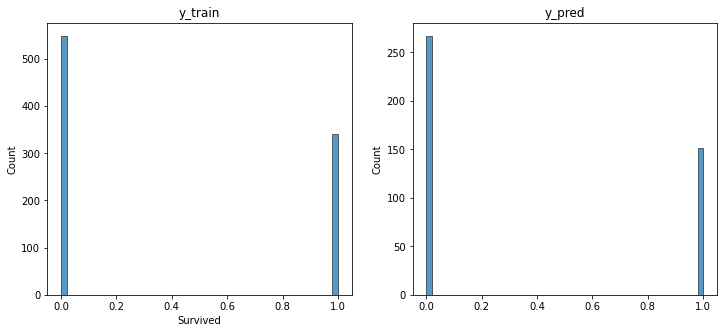

In [136]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.histplot(y_train, ax=ax1, bins=50)
ax1.set(title="y_train")

sns.histplot(y_pred, ax=ax2, bins=50)
ax2.set(title="y_pred")

* 제출용 CSV 만들기

In [137]:
submission = pd.read_csv("datasets/gender_submission.csv")
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [138]:
submission["Survived"] = y_pred
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [139]:
ver = 2 

submission.to_csv("datasets/ver_{0}_submission.csv".format(ver), index=False)